# TL;DR Solution

In the problem, we have to handle corrupted/noisy data. Lets do little bit of data to understand the corruption better.

In [ ]:
import pandas as pd
from pathlib import Path
from sklearn.linear_model import RANSACRegressor, LinearRegression

In [ ]:
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
SUB_PATH = "submission.csv"

train_df = pd.read_csv(TRAIN_PATH)
X_train = train_df[["feature1","feature2","feature3","feature4"]].values
y_train = train_df["target"].values

test_df = pd.read_csv(TEST_PATH)
X_test = test_df[["feature1","feature2","feature3","feature4"]].values
test_ids = test_df["ID"].values

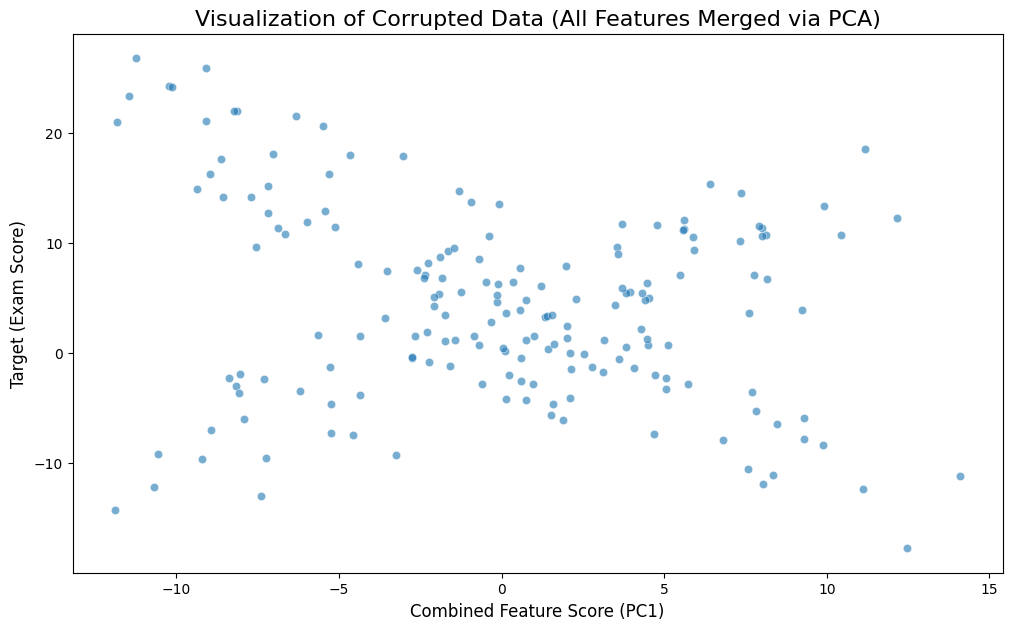

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)

train_df['combined_feature_score'] = X_train_pca

plt.figure(figsize=(12, 7))
sns.scatterplot(data=train_df, x='combined_feature_score', y='target', alpha=0.6)
plt.title('Visualization of Corrupted Data (All Features Merged via PCA)', fontsize=16)
plt.xlabel('Combined Feature Score (PC1)', fontsize=12)
plt.ylabel('Target (Exam Score)', fontsize=12)
plt.show()

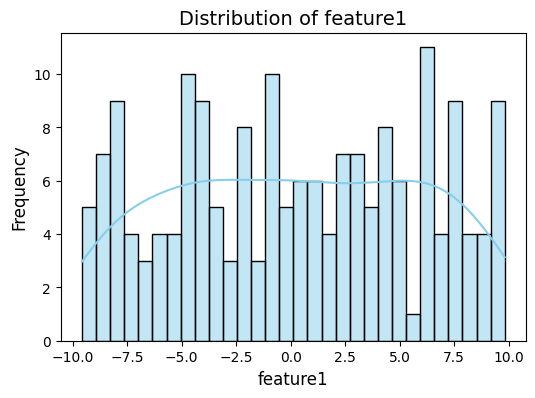

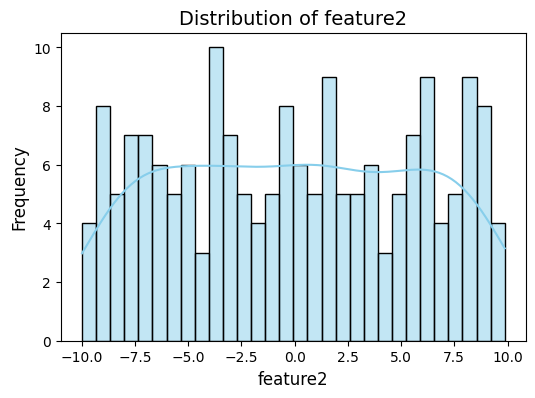

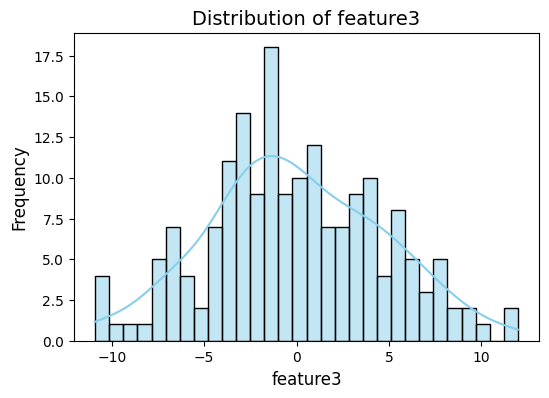

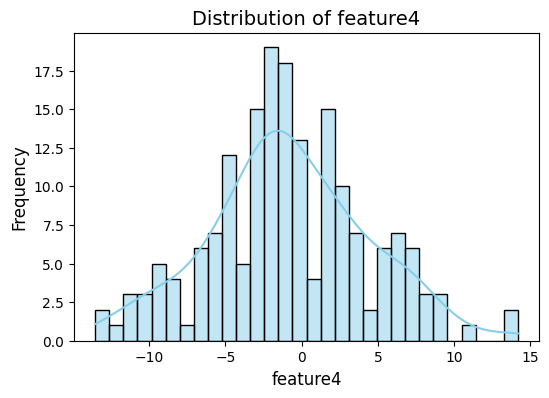

In [ ]:
features = ['feature1', 'feature2', 'feature3', 'feature4']

for col in features:
    plt.figure(figsize=(6,4))
    sns.histplot(train_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

First main point for best solution: The distributions of all features appear approximately gaussian.

Second main point: You can notice here that its X shaped. There is very simple explanation: The students corruption is the diagonale from top left to bottom right, while real data is the trend line from bottom left to top right. Or the corrupted one is from bottom left to top right. Our model must identify corrupted and real data, to perform well on test. There are many ways with handling this type of corrupted data, but best ones mainly involve inliner/outliner methods (Such as RANSAC (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html)) or soft clustering methods with weighted confidence (GMM (https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)).

RANSAC works very simply: It randomly samples data to get random subsets, fits base_estimator (which mostly is linear regression or any other model) to this random subset. After the model is fitted, checks the points which are agreeing with the fitted trendline within some threshold. This points are called inliners, while other points are outliers. This process is iterated overtime, and after n iteration, it chooses the mode which has largest number of inliners. This is how we did Solution A. This solution was made because of Main point 2.

GMM: We assume that the dat is generated from a mixture of several gaussian distributions. The algorithm tries to identify gaussian components. This is used because of Main point 1.

### Solution A:

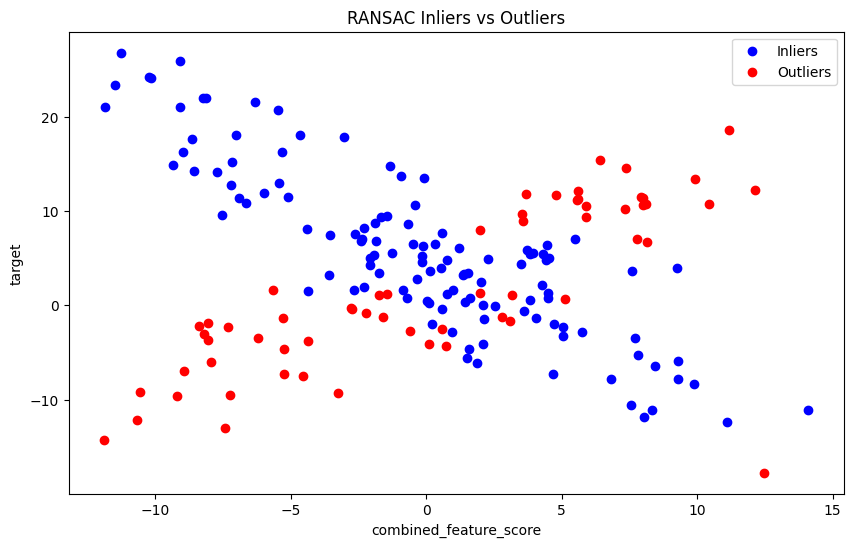

RANSAC identified 120 inliers (teacher data) and 60 outliers (student data).
Saved submission to submission.csv


In [ ]:
model = RANSACRegressor(
    estimator=LinearRegression(),
    random_state=42
)

model.fit(X_train, y_train)

inlier_mask = model.inlier_mask_
outlier_mask = ~inlier_mask
num_inliers = inlier_mask.sum()

plt.figure(figsize=(10,6))
plt.scatter(train_df['combined_feature_score'][inlier_mask], y_train[inlier_mask], color='blue', label='Inliers')
plt.scatter(train_df['combined_feature_score'][outlier_mask], y_train[outlier_mask], color='red', label='Outliers')
plt.xlabel('combined_feature_score')
plt.ylabel('target')
plt.legend()
plt.title('RANSAC Inliers vs Outliers')
plt.show()

num_outliers = len(y_train) - num_inliers
print(f"RANSAC identified {num_inliers} inliers (teacher data) and {num_outliers} outliers (student data).")

y_pred = model.predict(X_test)

submission_df = pd.DataFrame({
    "ID": test_ids,
    "Target": y_pred
})
submission_df.to_csv(SUB_PATH, index=False)
print(f"Saved submission to {SUB_PATH}")

### Solution B

Instead of linear regression, we use HuberRegressor and we do HPO to get better result.

In [ ]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

features = ["feature1", "feature2", "feature3", "feature4"]
X_train = train_df[features].values
y_train = train_df["target"].values
X_test = test_df[features].values
test_ids = test_df["ID"].values

huber = HuberRegressor()

ransac = RANSACRegressor(
    estimator=huber,
    min_samples=X_train.shape[1] + 1, # We have 4 features and model fits intercept itself, so w1x1+w2x2+...w4x4+b, (w1,w2,w3,w4,b). Min samples should contain all features.
    random_state=42
)

param_grid = {
    'residual_threshold': [1.0, 2.5, 5.0, 7.5],
    'estimator__epsilon': [1.1, 1.35, 1.5, 1.75]
}

grid_search = GridSearchCV(
    estimator=ransac,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# fitting parameters
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

### Deep Dive Solution C

In [ ]:
for feature in features:
    min_val = train_df[feature].min()
    max_val = train_df[feature].max()
    print(f"{feature}: min = {min_val}, max = {max_val}")

feature1: min = -9.566943988740045, max = 9.81557406457298
feature2: min = -9.98765842338056, max = 9.871535056010032
feature3: min = -10.898337182963903, max = 11.975992575658182
feature4: min = -13.534324731021464, max = 14.174913484160893


Instead of RANSAC, we can use gaussian mixture. First off we scale the features to reduce dominance within any feature (as we saw ranges, the diffrence between feature min/max isnt spotted, but lets avoid any problem)

Then we use GMM (Gaussian mixture model), which groups points to n clusters and assigns probability for each class. This is much more effective than RANSAC, because the access to probability will help the estimator model to choose it based on confidence of the point belonging to cluster.

Since we identified two clusters with probabilities, we want to know which one is teacher and which one is corrupt student. Thats why we can use correlation to see which clusters points are linearly dependand on Y.

Formula: corr = Covariance(X, Y)/std(X)*std(Y) (More: https://en.wikipedia.org/wiki/Correlation)

Higher the correlation, more linear dependance.

Since teacher models points are identified, we can use any base estimator with its weights being GMMs probability.


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

features = ["feature1", "feature2", "feature3", "feature4"]
X_train = train_df[features].values
y_train = train_df["target"].values
X_test = test_df[features].values
test_ids = test_df["ID"].values

full_train_data = train_df[features + ["target"]].values
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(full_train_data)


gmm = GaussianMixture(
    n_components=2,
    random_state=42,
    covariance_type='full',
    n_init=100,
    max_iter=200,
    tol=1e-4
)
gmm.fit(scaled_train_data)


cluster_probabilities = gmm.predict_proba(scaled_train_data)

teacher_id = -1
max = -1

for i in range(2):
    weights = cluster_probabilities[:, i]

    X_mean_effort = X_train.mean(axis=1)

    weighted_mean_x = np.average(X_mean_effort, weights=weights)
    weighted_mean_y = np.average(y_train, weights=weights)

    weighted_cov = np.average((X_mean_effort - weighted_mean_x) * (y_train - weighted_mean_y), weights=weights)

    weighted_std_x = np.sqrt(np.average((X_mean_effort - weighted_mean_x)**2, weights=weights))
    weighted_std_y = np.sqrt(np.average((y_train - weighted_mean_y)**2, weights=weights))

    correlation = weighted_cov / (weighted_std_x * weighted_std_y) # corr = cov/sig(x)*sig(y)
    print(f"  Cluster {i} Linearity Score (Weighted Correlation): {correlation:.4f}")

    if correlation > max:
        max = correlation
        teacher_id = i

print(f"{teacher_id}")

sample_weights = cluster_probabilities[:, teacher_id]

model = HuberRegressor()

model.fit(X_train, y_train, sample_weight=sample_weights)

  Cluster 0 Linearity Score (Weighted Correlation): -0.0494
  Cluster 1 Linearity Score (Weighted Correlation): 0.1098
1


HuberRegressor()

HPO can be done on huber or GMM to get better result. But for now this is fully enough. Public score = 0.011

Saving submission

In [ ]:
y_pred = model.predict(X_test)

submission_df = pd.DataFrame({
    "ID": test_ids,
    "Target": y_pred
})
submission_df.to_csv(SUB_PATH, index=False)

print(f"{SUB_PATH}.")

submission.csv.
